# All-dielectric structural colors

Structural colors are produced through the light manipulation at the nanoscale, where the periodic arrangement of materials dictates light phenomena such as reflection, diffraction, and interference. This approach offers a wide range of bright and vivid colors in various applications, ranging from displays and sensors to optical communication devices, without the need for traditional dyes or pigments. In this notebook we will use [Tidy3D](https://www.flexcompute.com/tidy3d/solver/) to simulate the optical response of an all-dielectric structural color metasurface, as proposed by `Bo Yang, Wenwei Liu, Zhancheng Li, Hua Cheng, Duk-Yong Choi, Shuqi Chen, and Jianguo Tian, "Ultrahighly Saturated Structural Colors Enhanced by Multipolar-Modulated Metasurfaces," Nano Letters 19(7), 4221-4228 (2019)` [DOI: 10.1021/acs.nanolett.8b04923](https://doi.org/10.1021/acs.nanolett.8b04923). 

Here, we will show how to use the [Design](https://docs.flexcompute.com/projects/tidy3d/en/v2.6.0rc1/api/plugins/design_readme.html) plugin, introduced in `Tidy3d` version 2.6.0, to programmatically define and run a parameter sweep and then use its convenient container for managing the resulting data. See the [Design Space Exploration Plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/) notebook for a detailed example on how to use it.

<img src="img/all_dielectric.png" alt="MIM"  width="400"/>

You can find related content in [MIM resonator](https://www.flexcompute.com/tidy3d/examples/notebooks/MIMResonator/), [Dielectric metasurface absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/DielectricMetasurfaceAbsorber/), and [CMOS RGB image sensor](https://www.flexcompute.com/tidy3d/examples/notebooks/CMOSRGBSensor/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it. 



First we will include all the libraries needed to run the notebook and also include the `Design` plugin as `tdd`.

In [9]:
# Standard python imports.
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import find_peaks
import pandas as pd

# Import regular tidy3d.
import tidy3d as td
import tidy3d.plugins.design as tdd

## Simulation Set Up

The device geometry is comprised of a periodic pattern of dielectric multilayer stacks. Each unit cell consists of a 60 nm thick $SiO_{3}N_{4}$ layer, a 140 nm thick $TiO_{2}$ spacer layer, and a 100 nm thick $SiO_{2}$ capping layer. The thin film multilayer was built by successive material depositions into a silica substrate. Below, we will define the device geometric parameters.

In [10]:
period = 0.35  # Unit cell period (um).
gap = 0.15  # Gap between adjacent unit cells (um).
sio2_thick = 0.10  # SiO2 dielectric thin film thickness (um).
tio2_thick = 0.14  # TiO2 dielectric thin film thickness (um).
si3n4_thick = 0.06  # Si3N4 dielectric thin film thickness (um).
sub_thick = 0.6  # SiO2 substrate thickness (um).
air_thick = 1.0  # Upper air layer thickness (um).

Material definition.

In [11]:
n_sio2 = 1.45  # SiO2 refractive index.
n_tio2 = 2.41  # TiO2 refractive index.
n_si3n4 = 2.00  # Si3N4 refractive index.

mat_sio2 = td.Medium(permittivity=n_sio2**2)  # SiO2.
mat_tio2 = td.Medium(permittivity=n_tio2**2)  # TiO2.
mat_si3n4 = td.Medium(permittivity=n_si3n4**2)  # Si3N4.
mat_air = td.Medium(permittivity=1)  # Air.

Next, we define the wavelength, frequencies, and other simulation parameters.

In [12]:
wl_min = 0.400  # Minimum simulation wavelength (um).
wl_max = 0.700  # Maximum simulation wavelength (um).
n_wl = 151  # Number of wavelength points within the simulation bandwidth.
wl_res = np.asarray([0.63, 0.52, 0.45])  # Resonance wavelengths of RGB pixels.
run_time = 2e-12  # Simulation run time (s).

wl_c = (wl_min + wl_max) / 2  # Central simulation wavelength (um).
wl_range = np.linspace(wl_min, wl_max, n_wl)  # Simulation wavelength range (um).
freq_c = td.C_0 / wl_c  # Central simulation frequency (Hz).
freq_range = td.C_0 / wl_range  # Simulation frequency range (Hz).
freq_bw = 0.5 * (freq_range[0] - freq_range[-1])  # Source bandwidth (Hz).
freq_res = td.C_0 / wl_res  # Resonance frequencies (Hz).

size_z = (
    sub_thick + si3n4_thick + tio2_thick + sio2_thick + air_thick
)  # Simulation size in the z-direction (um).

The next function defines the device unit cell. Here, we will define the dielectric stack structure, a plane wave source, and include a flux monitor to calculate the reflectance. The function accepts the unit cell `period` as an input parameter and returns a `Simulation` object. We will use it later as a pre-processing function to run the parameter sweep.

In [13]:
def build_sim(period: float = period) -> td.Simulation:
    """Builds the device simulation and returns a simulation object.
    Parameters:
        period: float
            Device unit cell period (um).
    Returns:
        sim: tidy3d.Simulation
            FDTD simulation object.
    """


    _inf = 10

    # Dielectric stack width (um).
    width = period - gap

    # Simulation size.
    size_x = period
    size_y = period

    # Substrate.
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-_inf, -_inf, -_inf), rmax=(_inf, _inf, -size_z / 2 + sub_thick)
        ),
        medium=mat_sio2,
    )

    # Si3N4 layer.
    si3n4_layer = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-width / 2, -width / 2, -size_z / 2 + sub_thick),
            rmax=(width / 2, width / 2, -size_z / 2 + sub_thick + si3n4_thick),
        ),
        medium=mat_si3n4,
    )

    # TiO2 layer.
    tio2_layer = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-width / 2, -width / 2, -size_z / 2 + sub_thick + si3n4_thick),
            rmax=(
                width / 2,
                width / 2,
                -size_z / 2 + sub_thick + si3n4_thick + tio2_thick,
            ),
        ),
        medium=mat_tio2,
    )

    # SiO2 layer.
    sio2_layer = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(
                -width / 2,
                -width / 2,
                -size_z / 2 + sub_thick + si3n4_thick + tio2_thick,
            ),
            rmax=(
                width / 2,
                width / 2,
                -size_z / 2 + sub_thick + si3n4_thick + tio2_thick + sio2_thick,
            ),
        ),
        medium=mat_sio2,
    )

    # Plane wave excitation source.
    plane_wave = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq_c, fwidth=freq_bw),
        size=(td.inf, td.inf, 0),
        center=(0, 0, size_z / 2 - wl_c / 2),
        direction="-",
        pol_angle=0,
        angle_theta=0,
    )

    # Flux monitor to measure the reflectance.
    ref_monitor = td.FluxMonitor(
        center=(0, 0, size_z / 2 - wl_c / 4),
        size=(td.inf, td.inf, 0),
        freqs=freq_range,
        name="R",
    )

    # Simulation
    sim = td.Simulation(
        size=(size_x, size_y, size_z),
        center=(0, 0, 0),
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=40, wavelength=(wl_min + wl_max) / 2
        ),
        structures=[substrate, si3n4_layer, tio2_layer, sio2_layer],
        sources=[plane_wave],
        monitors=[ref_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
        ),
        symmetry=(-1, 1, 0),
        medium=mat_air,
    )
    return sim

Before running any simulation, we will visually inspect the simulation setup.

In [14]:
sim = build_sim()
sim.plot_3d()

## Design Set Up

Now, we want to visualize how the device reflectance spectrum evolves when we vary the unit cell period from 0.3 $\mu m$ to 0.4 $\mu m$. Then, we will use the [Design](https://docs.flexcompute.com/projects/tidy3d/en/v2.6.0rc1/api/plugins/design_readme.html) plugin to perform a parameter sweep. 

The `Design` plugin uses the concept of [DesignSpace](https://docs.flexcompute.com/projects/tidy3d/en/v2.6.0rc1/api/_autosummary/tidy3d.plugins.design.DesignSpace.html#tidy3d.plugins.design.DesignSpace), which gathers the design method and design parameters in a single object. So, we will start by defining our design parameter as a [tdd.ParameterFloat](https://docs.flexcompute.com/projects/tidy3d/en/v2.6.0rc1/api/_autosummary/tidy3d.plugins.design.ParameterFloat.html#tidy3d.plugins.design.ParameterFloat) instance and give it a range.

> Note: we need to ensure that the parameter name argument matches the function argument name in our `build_sim()` function, which we will use to construct the simulations for the parameter sweep.

In [15]:
param_p = tdd.ParameterFloat(name="period", span=(0.3, 0.4), num_points=11)

Next, we will define a [tdd.MethodGrid](https://docs.flexcompute.com/projects/tidy3d/en/v2.6.0rc1/api/_autosummary/tidy3d.plugins.design.MethodGrid.html#tidy3d.plugins.design.MethodGrid) which allows for a grid search over the parameter space, and then combine everything into a [tdd.DesignSpace](https://docs.flexcompute.com/projects/tidy3d/en/v2.6.0rc1/api/_autosummary/tidy3d.plugins.design.DesignSpace.html#tidy3d.plugins.design.DesignSpace).

In [16]:
method = tdd.MethodGrid()
design_space = tdd.DesignSpace(parameters=[param_p], method=method, task_name="GridSearch_Notebook", path_dir="./data")

To run the parameter sweep, we need to define `pre`- and `post`-processing functions to respectively create the simulations and process their results. That enables the design plugin to take advantage of parallelism to perform `Batch` processing under the hood. 

Our `pre`-processing function is the `build_sim()` function defined before. In our `post`-processing function, we will illustrate how to return single values, like the reflectance peak value and wavelength, as well as multidimensional data as the raw monitor dataset.

In [17]:
# Post-processing function.
def fn_post(sim_data: td.SimulationData) -> dict:
    """Pos-processing function to calculate and return the reflectance peak 
    in addition to the reflectance FluxMonitor.
    Parameters:
        sim_data: tidy3d.SimulationData
            Simulation data object where to get results from.
    Returns:
        dict:
            A dictionary containing the reflectance monitor,
            the reflectance peak and wavelength.
    """    
    R_data = sim_data["R"]
    R = R_data.flux.values
    wavelength = td.C_0 / R_data.flux.f.values
    peaks_id, _ = find_peaks(R, height=0.6)
    peak_R = R[peaks_id[0]]
    peak_wvl = wavelength[peaks_id[0]]
    return {
        "Reflectance": R_data,
        "Peak Reflectance": peak_R,
        "Peak Wavelength": peak_wvl,
    }

## Run Design

Finally, we will pass our pre-processing and post-processing functions to the `DesignSpace.run()` method to get our results. The `DesignSpace` will combine all our `Simulation` objects into a single `Batch` and then process them individually after the computation has completed on the `Tidy3D` cloud.

In [18]:
results = design_space.run(fn=build_sim, fn_post=fn_post, verbose=True)

11:47:45 BST Running 11 Simulations

## Design Results

To analyze the design results we will create a `dataframe` using the `to_dataframe()` method. This dataframe shows the sweep parameter `period` as well as the post-processing function results. As one can see, we can return single values like `Peak Reflectance` and `Peak Wavelength`, or higher dimensional datasets such as `FluxMonitor` dataset included in the `Reflectance` column.

In [19]:
df = results.to_dataframe()
df

,period,Reflectance,Peak Reflectance,Peak Wavelength
0,0.30,attrs={} type='FluxData' monitor=FluxMonitor(a...,1.013400,0.444
1,0.31,attrs={} type='FluxData' monitor=FluxMonitor(a...,1.011983,0.464
2,0.32,attrs={} type='FluxData' monitor=FluxMonitor(a...,0.999921,0.482
3,0.33,attrs={} type='FluxData' monitor=FluxMonitor(a...,0.996108,0.502
4,0.34,attrs={} type='FluxData' monitor=FluxMonitor(a...,0.995061,0.520
5,0.35,attrs={} type='FluxData' monitor=FluxMonitor(a...,0.997230,0.538
6,0.36,attrs={} type='FluxData' monitor=FluxMonitor(a...,0.996575,0.556
7,0.37,attrs={} type='FluxData' monitor=FluxMonitor(a...,0.998574,0.572
8,0.38,attrs={} type='FluxData' monitor=FluxMonitor(a...,0.992553,0.588
9,0.39,attrs={} type='FluxData' monitor=FluxMonitor(a...,0.990022,0.606


We can use the built-in dataframe functions to plot and analyze information. For instance, let's plot the peak reflectance values and wavelengths to observe how these values change with respect to device period.

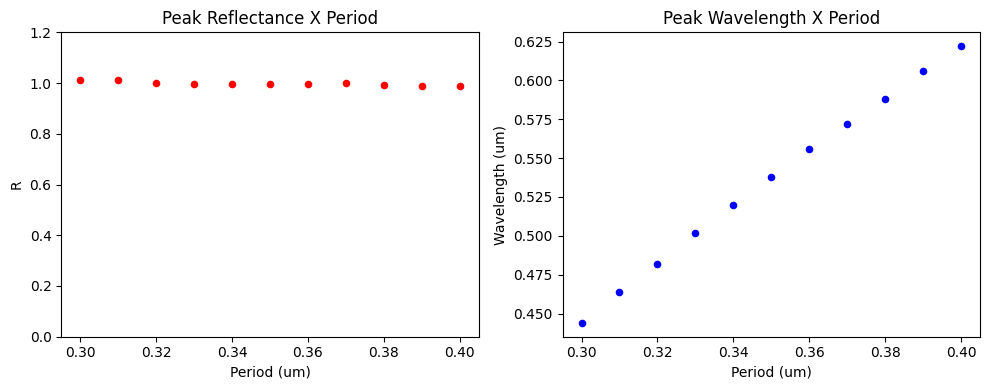

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
df.plot(
    x="period",
    y="Peak Reflectance",
    kind="scatter",
    ax=ax1,
    title="Peak Reflectance X Period",
    xlabel="Period (um)",
    ylabel="R",
    ylim=[0, 1.2],
    color="Red",
)
df.plot(
    x="period",
    y="Peak Wavelength",
    kind="scatter",
    ax=ax2,
    title="Peak Wavelength X Period",
    xlabel="Period (um)",
    ylabel="Wavelength (um)",
    color="Blue",
)
plt.show()

As one can see, the reflectance peak is very robust with respect to device period. On the other hand, an almost linear relationship is shown between the reflectance peak and the device period. These results are in agreement to the ones in the reference paper. 

Now, we will create another dataframe to plot the reflectance spectrum versus wavelength for the different device periods. Here, we will unpack the `FluxMonitor` dataset and access the flux values and frequencies.

In [21]:
df_wl = pd.DataFrame({"Wavelength": td.C_0 / df.loc[0, "Reflectance"].flux.f.values})
df_R = pd.DataFrame(
    {df.loc[i, "period"]: df.loc[i, "Reflectance"].flux.values for i in df.index}
)
df_R_wl = pd.concat([df_wl, df_R], axis=1)
df_R_wl.set_index("Wavelength", inplace=True)
df_R_wl.head()

,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4
Wavelength,,,,,,,,,,,
0.400,0.027934,0.012221,0.006994,0.004800,0.002578,0.002097,0.002714,0.004103,0.006655,0.107131,0.011689
0.402,0.029462,0.012628,0.007091,0.005310,0.002887,0.002008,0.002290,0.003308,0.005033,0.334392,0.007037
0.404,0.031189,0.012861,0.007163,0.005758,0.003348,0.002061,0.002017,0.002702,0.003983,0.206805,0.009618
0.406,0.033187,0.013244,0.007267,0.006094,0.003874,0.002278,0.001882,0.002263,0.003114,0.048599,0.013553
0.408,0.035545,0.013807,0.007111,0.006287,0.004486,0.002584,0.001875,0.001946,0.002429,0.016116,0.021841


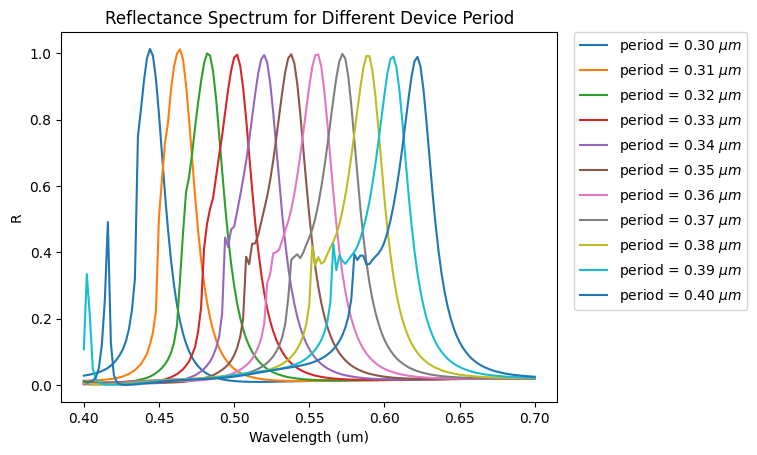

In [22]:
ax = df_R_wl.plot(
    title="Reflectance Spectrum for Different Device Period",
    xlabel="Wavelength (um)",
    ylabel="R",
)
ax.legend([f"period = {p:.2f} $\\mu m$" for p in df_R_wl.columns],
          bbox_to_anchor=(1.02, 1.02), 
          loc='upper left')
plt.show()